In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from scipy.stats import randint, uniform

# Definir ruta del dataset
CSV_PATH = "ventas_2025-10-02.csv"  
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Parámetros dinámicos para el churn
ALPHA = 3.0
MIN_DAYS = 15
MAX_DAYS = 180

# Cargar dataset
df = pd.read_csv(CSV_PATH)

# Combinar fecha y hora en una sola columna de tipo datetime
date = pd.to_datetime(df["CreadoEl"], dayfirst=True, errors="coerce")
hora = df["Hora"].astype(str).str.strip()
hora = np.where(hora.str.match(r"^\d{1,2}:\d{2}$"), hora + ":00", hora)
time_delta = pd.to_timedelta(hora, errors="coerce")
df["dt"] = date + time_delta.fillna(pd.Timedelta(0))

# Limpiar valores de importe
def to_number_vec(s):
    s = s.astype(str).str.replace(r"[.\s$ARSa-zA-Z]", "", regex=True)
    s = s.str.replace(",", ".", regex=False)
    return pd.to_numeric(s, errors="coerce")

df["ValorNeto_num"] = to_number_vec(df["ValorNeto"])

# Definir columna de cliente
key_col = "Cliente" if "Cliente" in df.columns else "CUIT"

# Ordenar por tiempo
df = df.sort_values([key_col, "dt"]).reset_index(drop=True)
cutoff_dt = df["dt"].max() # La fecha de corte es la fecha de la ultima venta en el dataset


/var/folders/y0/404pxmfn357ftb9snt8c2x4r0000gn/T/ipykernel_37657/1486545889.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date = pd.to_datetime(df["CreadoEl"], dayfirst=True, errors="coerce")


In [ ]:
# Diferencia en días entre compras por cliente y se hace un promedio
df["diff_days"] = df.groupby(key_col)["dt"].diff().dt.days
mean_gap = df.groupby(key_col)["diff_days"].mean().rename("mean_gap")
global_median_gap = df["diff_days"].dropna().median()
mean_gap = mean_gap.fillna(global_median_gap)

# Umbral dinámico: multiplica su frecuencia normal por ALPHA, limitado por MIN_DAYS y MAX_DAYS
dyn_threshold = (ALPHA * mean_gap).clip(lower=MIN_DAYS, upper=MAX_DAYS).rename("dyn_threshold")

# Días desde la última compra: buscamos ultima fecha de compra por cliente y calculamos diferencia con fecha de corte (esto sería la recencia)
last_purchase = df.groupby(key_col)["dt"].max().rename("last_purchase_dt")
days_since_last = (cutoff_dt - last_purchase).dt.days.rename("days_since_last")

# Etiqueta churn: 1 si superó el umbral dinámico. Variable objetivo.
label = (days_since_last > dyn_threshold).astype(int).rename("churn")


In [ ]:
# Transformar datos transaccionales en datos por cliente y distingumos features de comportamiento y agregados
agg_dict = {
    "Documento": "count",
    "ValorNeto_num": ["sum", "mean", "std", "median"],
    "Vendedor": pd.Series.nunique,
    "Oficina": pd.Series.nunique,
    "Localidad": pd.Series.nunique,
}

features = df.groupby(key_col).agg(agg_dict)
features.columns = ["_".join(c) if isinstance(c, tuple) else c for c in features.columns]
features = features.rename(columns={"Documento_count": "n_purchases"})

cust_df = pd.concat([features, mean_gap, dyn_threshold, last_purchase, days_since_last, label], axis=1)
first_purchase = df.groupby(key_col)["dt"].min().rename("first_purchase_dt")
cust_df = cust_df.join(first_purchase)

# Agregar features adicionales
cust_df["tenure_days"] = (cutoff_dt - cust_df["first_purchase_dt"]).dt.days # Antigüedad del cliente en días
cust_df["purchases_per_90d"] = cust_df["n_purchases"] / (cust_df["tenure_days"] / 90.0).replace(0, np.nan) # Frecuencia de compras por cada 90 días
cust_df["recency_days"] = cust_df["days_since_last"] # Recencia en días
cust_df["monetary_mean"] = cust_df.get("ValorNeto_num_mean", np.nan) # Valor monetario promedio
cust_df["monetary_sum"] = cust_df.get("ValorNeto_num_sum", np.nan) # Valor monetario total

cust_df = cust_df.reset_index().rename(columns={key_col: "cliente_id"})
cust_df.head()


,cliente_id,n_purchases,ValorNeto_num_sum,ValorNeto_num_mean,ValorNeto_num_std,ValorNeto_num_median,Vendedor_nunique,Oficina_nunique,Localidad_nunique,mean_gap,dyn_threshold,last_purchase_dt,days_since_last,churn,first_purchase_dt,tenure_days,purchases_per_90d,recency_days,monetary_mean,monetary_sum
0,5,1817,1.403819e+09,772602.559774,729299.429540,690083.880,1,1,1,0.350220,15.0,2025-09-30,0,0,2024-01-03,636,257.122642,0,772602.559774,1.403819e+09
1,8,2122,1.717844e+09,809539.847743,767350.064752,654888.945,1,1,1,0.300330,15.0,2025-09-30,0,0,2024-01-02,637,299.811617,0,809539.847743,1.717844e+09
2,9,1114,4.824796e+08,433105.589632,350738.538884,387101.125,1,1,1,0.566038,15.0,2025-09-30,0,0,2024-01-09,630,159.142857,0,433105.589632,4.824796e+08
3,20,1640,1.132321e+09,690439.607409,658398.985418,604659.995,1,1,1,0.388652,15.0,2025-09-30,0,0,2024-01-02,637,231.711146,0,690439.607409,1.132321e+09
4,23,2028,3.681706e+08,181543.700192,244441.608950,82389.805,1,1,1,0.314258,15.0,2025-09-30,0,0,2024-01-02,637,286.530612,0,181543.700192,3.681706e+08


In [ ]:
# Definimos la columna objetivo
target_col = "churn"

# División entrenamiento y test 
X = cust_df.select_dtypes(include=[np.number]).drop(columns=["churn"], errors="ignore")
y = cust_df[target_col].astype(int)

X = X.fillna(X.median(numeric_only=True))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Preprocesamiento (escalado) y definición de modelos
preprocess = ColumnTransformer([("num", StandardScaler(), X.columns)], remainder="drop")

models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=RANDOM_STATE),
}

# Validación cruzada estratificada y evaluación de modelos

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Pipeline de entrenamiento y evaluación por modelo 
results = {}
for name, model in models.items():
    pipe = Pipeline([("prep", preprocess), ("clf", model)])
    scores = cross_validate(pipe, X_train, y_train, scoring="roc_auc", cv=cv, n_jobs=-1)
    results[name] = scores["test_score"].mean()

pd.DataFrame.from_dict(results, orient="index", columns=["ROC_AUC"]).sort_values(by="ROC_AUC", ascending=False)


,ROC_AUC
HistGradientBoosting,0.998617
Logistic Regression,0.998490
Random Forest,0.992076


In [11]:
# Rehacemos el entrenamiento y la comparación de modelos excluyendo variables con leakage
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

RANDOM_STATE = 42

# Construir X,y SI NO ESTUVIESEN ya definidos (caso autosuficiente):
if 'cust_df' in globals():
    target_col = 'churn'
    candidate_num = [c for c in cust_df.columns 
                     if c not in ['cliente_id','churn','last_purchase_dt','first_purchase_dt'] 
                     and np.issubdtype(cust_df[c].dtype, np.number)]
    X_all = cust_df[candidate_num].copy()
    y_all = cust_df[target_col].astype(int).copy()
else:
    X_all = X.copy()
    y_all = y.copy()

# Quitar variables con leakage (derivadas del label)
leaky_cols = [c for c in ['days_since_last','dyn_threshold','mean_gap','recency_days'] if c in X_all.columns]
X_safe = X_all.drop(columns=leaky_cols)

# Imputación simple y split
X_safe = X_safe.replace([np.inf, -np.inf], np.nan)
X_safe = X_safe.fillna(X_safe.median(numeric_only=True))

X_train, X_test, y_train, y_test = train_test_split(
    X_safe, y_all, test_size=0.2, stratify=y_all, random_state=RANDOM_STATE
)

# Preprocesamiento + modelos
preprocess = ColumnTransformer([("num", StandardScaler(), X_safe.columns)], remainder="drop")

models_safe = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=RANDOM_STATE)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Definición de pipeline y evaluación
rows = []
for name, model in models_safe.items():
    pipe = Pipeline([("prep", preprocess), ("clf", model)])
    scores = cross_validate(
        pipe, X_train, y_train,
        scoring=["roc_auc", "f1", "precision", "recall", "accuracy"],
        cv=cv, n_jobs=-1, return_train_score=True
    )
    rows.append({
        "model": name,
        "roc_auc_mean": scores["test_roc_auc"].mean(),
        "f1_mean": scores["test_f1"].mean(),
        "precision_mean": scores["test_precision"].mean(),
        "recall_mean": scores["test_recall"].mean(),
        "accuracy_mean": scores["test_accuracy"].mean(),
        "roc_auc_train_mean": scores["train_roc_auc"].mean()
    })

comp_safe = pd.DataFrame(rows).sort_values("roc_auc_mean", ascending=False)
comp_safe


/Users/facundo/Documents/proyecto/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,model,roc_auc_mean,f1_mean,precision_mean,recall_mean,accuracy_mean,roc_auc_train_mean
1,Random Forest,0.907581,0.520769,0.693095,0.436190,0.912657,1.000000
2,HistGradientBoosting,0.896297,0.491138,0.587357,0.436190,0.901746,1.000000
0,Logistic Regression,0.885773,0.101507,0.383333,0.058571,0.887568,0.887267


In [ ]:
# Elegimos el modelo sin variables con leakage y hacemos tuning + evaluación exhaustiva + diagnóstico
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV, cross_validate
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    brier_score_loss, classification_report, confusion_matrix
)
from sklearn.pipeline import Pipeline

best_name = comp_safe.iloc[0]['model']

if best_name == "Random Forest":
    base = RandomForestClassifier(random_state=RANDOM_STATE)
    param_dist = {
        "clf__n_estimators": randint(200, 800),
        "clf__max_depth": randint(3, 24),
        "clf__min_samples_split": randint(2, 20),
        "clf__min_samples_leaf": randint(1, 12),
        "clf__max_features": ["sqrt", "log2", None],
    }
elif best_name == "HistGradientBoosting":
    base = HistGradientBoostingClassifier(random_state=RANDOM_STATE)
    param_dist = {
        "clf__max_depth": randint(3, 16),
        "clf__learning_rate": uniform(0.01, 0.2),
        "clf__max_leaf_nodes": randint(15, 63),
        "clf__l2_regularization": uniform(0.0, 1.0),
    }
else: 
    base = LogisticRegression(max_iter=500)
    param_dist = {"clf__C": uniform(0.01, 10.0)}

tune_pipe = Pipeline([("prep", preprocess), ("clf", base)])
search = RandomizedSearchCV(
    estimator=tune_pipe, param_distributions=param_dist,
    n_iter=20, scoring="roc_auc", cv=cv, n_jobs=-1, random_state=RANDOM_STATE, verbose=1
)
search.fit(X_train, y_train)

best_pipe = search.best_estimator_

# Evaluación exhaustiva en TEST
y_pred = best_pipe.predict(X_test)

# Probabilidades para AUC, Brier y RMSE
try:
    y_proba = best_pipe.predict_proba(X_test)[:, 1]
except Exception:
    # fallback para modelos sin predict_proba
    from sklearn.utils.extmath import softmax
    dec = best_pipe.decision_function(X_test)
    # escalar a [0,1]
    y_proba = (dec - dec.min()) / (dec.max() - dec.min() + 1e-9)

acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)
auc = roc_auc_score(y_test, y_proba)
brier = brier_score_loss(y_test, y_proba)         # MSE de probas
rmse_prob = np.sqrt(brier)                         # “RMSE” de probas (interpretación estilo regresión)

print("== Test metrics ==")
print(f"ROC-AUC : {auc:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}")
print(f"Brier score (MSE probas): {brier:.4f}  |  RMSE probas: {rmse_prob:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# Diagnóstico de Over/Under-fitting con CV en TRAIN
cv_diag = cross_validate(
    best_pipe,
    X_train,
    y_train,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    return_train_score=True
)

keys = list(cv_diag.keys())
print("Keys disponibles en cross_validate:", keys)

# Buscar las claves de train y test dinámicamente
train_key = next((k for k in keys if "train" in k), None)
test_key = next((k for k in keys if "test" in k), None)

train_auc = np.mean(cv_diag[train_key])
valid_auc = np.mean(cv_diag[test_key])

print("\n== Diagnóstico CV (ROC-AUC) ==")
print(f"Train AUC mean : {train_auc:.4f}")
print(f"Valid AUC mean : {valid_auc:.4f}")

gap = train_auc - valid_auc

if gap > 0.03:
    print("\n Posible OVERFITTING (train >> valid)")
elif valid_auc < 0.65:
    print("\n Posible UNDERFITTING (validación baja).")
else:
    print("\nAjuste razonable (sin señales fuertes de over/under-fitting).")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
== Test metrics ==
ROC-AUC : 0.9219
Accuracy: 0.9214
Precision: 0.9000  Recall: 0.3462  F1: 0.5000
Brier score (MSE probas): 0.0619  |  RMSE probas: 0.2488

Classification report:
              precision    recall  f1-score   support

           0      0.922     0.995     0.957       203
           1      0.900     0.346     0.500        26

    accuracy                          0.921       229
   macro avg      0.911     0.671     0.729       229
weighted avg      0.920     0.921     0.905       229

Confusion matrix:
 [[202   1]
 [ 17   9]]
Keys disponibles en cross_validate: ['fit_time', 'score_time', 'test_score', 'train_score']

== Diagnóstico CV (ROC-AUC) ==
Train AUC mean : 0.9543
Valid AUC mean : 0.9115

 Posible OVERFITTING (train >> valid)


== Test metrics (modelo regularizado) ==
ROC-AUC : 0.9219
Accuracy: 0.9214
Precision: 0.9000  Recall: 0.3462  F1: 0.5000
Brier score (MSE probas): 0.0619  |  RMSE probas: 0.2488

== Diagnóstico CV (ROC-AUC) | Modelo regularizado ==
Train AUC mean : 0.9543
Valid AUC mean : 0.9115
Gap (train - valid): 0.0428


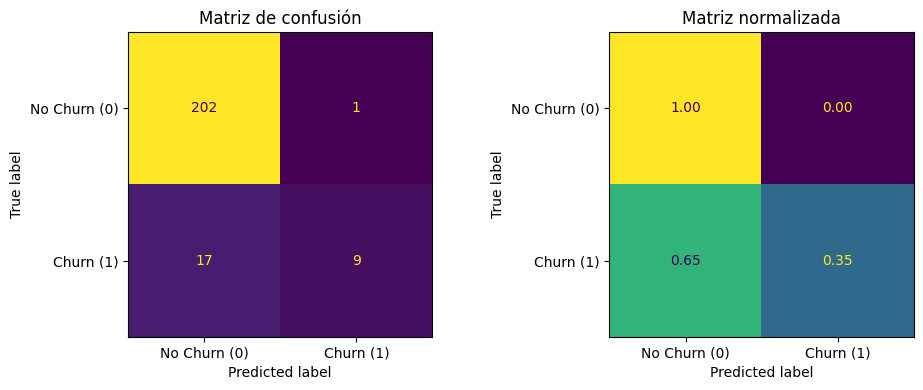

In [13]:
# Mitigar overfitting, evaluar y graficar matriz de confusión
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_recall_fscore_support, roc_auc_score, brier_score_loss
)
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

# Construir un clasificador más "regularizado" según el modelo ganador
def regularize_classifier(clf):
    """Devuelve una copia del clasificador con hiperparámetros más conservadores para reducir overfitting."""
    if isinstance(clf, RandomForestClassifier):
        new = clone(clf)
        # Limitar complejidad de los árboles
        new.set_params(
            max_depth= min(10, (clf.max_depth or 12)),
            min_samples_leaf = max(3, getattr(clf, "min_samples_leaf", 1)),
            min_samples_split = max(6, getattr(clf, "min_samples_split", 2)),
            max_features = "sqrt",
            n_estimators = max(300, getattr(clf, "n_estimators", 300)),
            bootstrap = True
        )
        return new

    if isinstance(clf, HistGradientBoostingClassifier):
        new = clone(clf)
        # Más regularización y menos profundidad
        new.set_params(
            max_depth = min(6, getattr(clf, "max_depth", 6) or 6),
            learning_rate = min(0.06, getattr(clf, "learning_rate", 0.1)),
            max_leaf_nodes = min(31, getattr(clf, "max_leaf_nodes", 31) or 31),
            l2_regularization = max(0.1, getattr(clf, "l2_regularization", 0.0)),
            early_stopping = True,
            validation_fraction = 0.1,
            n_iter_no_change = 10
        )
        return new

    if isinstance(clf, LogisticRegression):
        new = clone(clf)
        current_C = getattr(clf, "C", 1.0)
        new.set_params(C=max(0.3, current_C/2), penalty="l2", class_weight=None)
        return new

    return clone(clf)

# Reconstruir el pipeline con más regularización y re-entrenar
assert "best_pipe" in globals(), "No encuentro best_pipe. Ejecutá la celda de tuning previa."
base_clf = best_pipe.named_steps["clf"]
reg_clf  = regularize_classifier(base_clf)

reg_pipe = Pipeline([("prep", preprocess), ("clf", reg_clf)])
reg_pipe.fit(X_train, y_train)

# Métricas en TEST 
y_pred = reg_pipe.predict(X_test)
try:
    y_proba = reg_pipe.predict_proba(X_test)[:, 1]
except Exception:
    dec = reg_pipe.decision_function(X_test)
    y_proba = (dec - dec.min()) / (dec.max() - dec.min() + 1e-9)

acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)
auc = roc_auc_score(y_test, y_proba)
brier = brier_score_loss(y_test, y_proba)
rmse_prob = np.sqrt(brier)

print("== Test metrics (modelo regularizado) ==")
print(f"ROC-AUC : {auc:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}")
print(f"Brier score (MSE probas): {brier:.4f}  |  RMSE probas: {rmse_prob:.4f}")

# Diagnóstico de Over/Under-fitting con CV en TRAIN
cv_diag = cross_validate(reg_pipe, X_train, y_train, scoring="roc_auc", cv=cv, n_jobs=-1, return_train_score=True)
train_auc = np.mean(cv_diag["train_score"])
valid_auc = np.mean(cv_diag["test_score"])
gap = train_auc - valid_auc
print("\n== Diagnóstico CV (ROC-AUC) | Modelo regularizado ==")
print(f"Train AUC mean : {train_auc:.4f}")
print(f"Valid AUC mean : {valid_auc:.4f}")
print(f"Gap (train - valid): {gap:.4f}")

# Graficar matriz de confusión absoluta y normalizada
cm = confusion_matrix(y_test, y_pred)
cm_norm = confusion_matrix(y_test, y_pred, normalize="true")
labels = ["No Churn (0)", "Churn (1)"]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
disp1 = ConfusionMatrixDisplay(cm, display_labels=labels)
disp1.plot(ax=axes[0], colorbar=False)
axes[0].set_title("Matriz de confusión")

disp2 = ConfusionMatrixDisplay(cm_norm, display_labels=labels)
disp2.plot(ax=axes[1], colorbar=False, values_format=".2f")
axes[1].set_title("Matriz normalizada")
plt.tight_layout()
plt.show()
